In [1]:
import imagej
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# initialize ImageJ
ij = imagej.init('sc.fiji:fiji:2.14.0') 
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.14.0/1.54f


In [13]:
def tif_preprocessing(n): #Returns cleaned up image as NumPy array
    
    original = np.asarray(ij.py.from_java(n))

    ij.IJ.run(n, "Convert to Mask", '125')

    for i in range(1):
        ij.IJ.run(n, "Despeckle", "")

    noisy = np.asarray(ij.py.from_java(n))

    for i in range(1):
        ij.IJ.run(n, "Subtract Background...", "rolling=2")

    noise = np.asarray(ij.py.from_java(n))

    cleaned_up = noisy - noise

    #binary_mask = cleaned_up / 255 # White pixels get value 1 - Black pixels get value 0
    #final = binary_mask * original

    #rows = cleaned_up.shape[0]
    #cutoff = int(rows * 0.934)  
    #final = final[:cutoff, :]

    return cleaned_up

In [14]:
import tifffile as tiff
from scipy import ndimage


imp = ij.IJ.openImage(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\2ps\EDS\Electron Image 1.tiff")
#orig = np.asarray(ij.py.from_java(imp)).astype(np.uint8).sum(axis=2) / np.max(np.asarray(ij.py.from_java(imp)).astype(np.uint8).sum(axis=2))
ij.IJ.setThreshold(imp, 220, 255)
ij.IJ.run(imp, "Convert to Mask", "")
original = np.asarray(ij.py.from_java(imp)).astype(np.uint8)
#original = original.sum(axis=2)
#original = original / np.max(original)
original = original[:768, :]
print(np.shape(original))

imp_Fe = ij.IJ.openImage(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\2ps\EDS\Fe K_alpha_1 Map Data 1.tif")
ij.IJ.setThreshold(imp_Fe, 220, 255)
ij.IJ.run(imp_Fe, "Convert to Mask", "")

Fe_noisy = np.asarray(ij.py.from_java(imp_Fe))
#ij.IJ.run(imp_Fe, "Subtract Background...", "rolling=1")
#ij.IJ.run(imp_Fe, "Despeckle", "")
#Fe_noise = np.asarray(ij.py.from_java(imp_Fe))
arrayFe = Fe_noisy #- Fe_noise

imp_Si = ij.IJ.openImage(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\2ps\EDS\Si K_alpha_1 Map Data 1.tif")
ij.IJ.run(imp_Si, "Convert to Mask", '125')
arraySi = np.asarray(ij.py.from_java(imp_Si))

#print(np.shape(arrayFe))

#Fe = arrayFe.sum(axis=2)

#Si = arraySi.sum(axis=2)

Fe_normalized = arrayFe / np.max(arrayFe)

Si_normalized = arraySi / np.max(arraySi)

Fe = Fe_normalized > 0.1
Si = Si_normalized > 0.1

#print(np.unique(Fe))
#print(f"array_Fe: {Fe}")
#print(np.unique(Si))

Si_filled = ndimage.binary_fill_holes(Si)
Si_closed = ndimage.binary_closing(Si_filled, structure=np.ones((20, 20)))

Fe_filled = ndimage.binary_fill_holes(Fe)
Fe_cleaned_up = ndimage.binary_opening(Fe_filled, structure=np.ones((2, 2)))
Fe_closed = ndimage.binary_closing(Fe_cleaned_up, structure=np.ones((10, 10)))




combined = Fe_cleaned_up * Si_closed


Fe_normalized

(768, 1024)


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

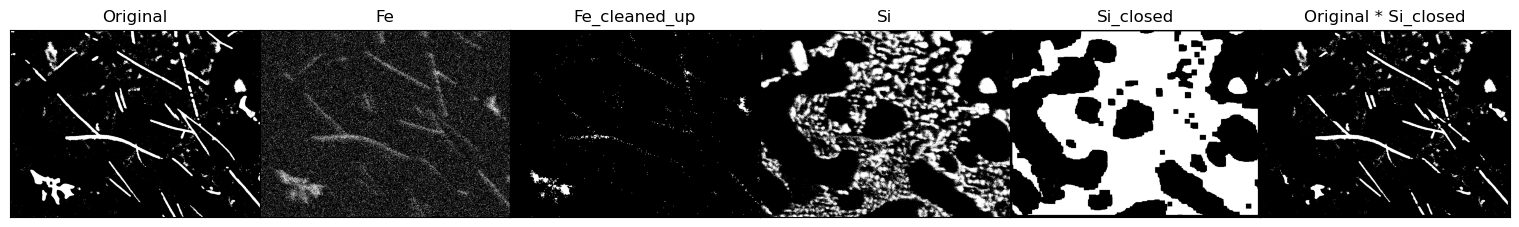

In [15]:
fig, axarr = plt.subplots(1, 6)

axarr[0].imshow(original, cmap ="Greys_r")
axarr[1].imshow(Fe, cmap ="Greys_r")
axarr[2].imshow(Fe_cleaned_up, cmap ="Greys_r")
axarr[3].imshow(Si, cmap = "Greys_r")
axarr[4].imshow(Si_closed, cmap = "Greys_r")
axarr[5].imshow(original * Si_closed, cmap = "Greys_r")


axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[2].set_xticks([])
axarr[2].set_yticks([])
axarr[3].set_xticks([])
axarr[3].set_yticks([])
axarr[4].set_xticks([])
axarr[4].set_yticks([])
axarr[5].set_xticks([])
axarr[5].set_yticks([])

axarr[0].set_title('Original')
axarr[1].set_title('Fe')
axarr[2].set_title('Fe_cleaned_up')
axarr[3].set_title('Si')
axarr[4].set_title('Si_closed')
axarr[5].set_title('Original * Si_closed')



fig.subplots_adjust(left=0,bottom=0, right=1, top=1, hspace=0, wspace=0)

fig.set_figheight(3)
fig.set_figwidth(15)
fig.savefig("Original_Si_closed", dpi=300)

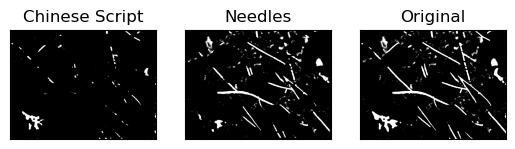

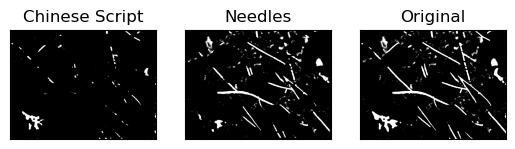

In [16]:
fig, axarr = plt.subplots(1, 3)

axarr[0].imshow(original - (original * Si_closed), cmap = 'Greys_r')
axarr[1].imshow((original * Si_closed), cmap = 'Greys_r')
axarr[2].imshow(original, cmap = 'Greys_r')
#axarr[3].imshow(orig, cmap = 'Greys_r')


axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[2].set_xticks([])
axarr[2].set_yticks([])
#axarr[3].set_xticks([])
#axarr[3].set_yticks([])

axarr[0].set_title('Chinese Script')
axarr[1].set_title('Needles')
axarr[2].set_title('Original after preprocessing')
axarr[2].set_title('Original')

fig

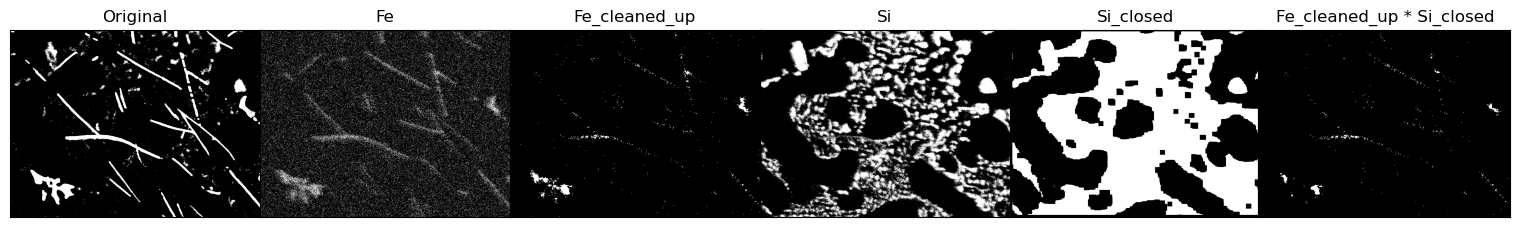

In [17]:
fig, axarr = plt.subplots(1, 6)

axarr[0].imshow(original,cmap ="Greys_r")
axarr[1].imshow(Fe, cmap ="Greys_r")
axarr[2].imshow(Fe_cleaned_up, cmap ="Greys_r")
axarr[3].imshow(Si, cmap = "Greys_r")
axarr[4].imshow(Si_closed, cmap = "Greys_r")
axarr[5].imshow(Fe_cleaned_up * Si_closed, cmap = "Greys_r")


axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[2].set_xticks([])
axarr[2].set_yticks([])
axarr[3].set_xticks([])
axarr[3].set_yticks([])
axarr[4].set_xticks([])
axarr[4].set_yticks([])
axarr[5].set_xticks([])
axarr[5].set_yticks([])

axarr[0].set_title('Original')
axarr[1].set_title('Fe')
axarr[2].set_title('Fe_cleaned_up')
axarr[3].set_title('Si')
axarr[4].set_title('Si_closed')
axarr[5].set_title('Fe_cleaned_up * Si_closed')



fig.subplots_adjust(left=0,bottom=0, right=1, top=1, hspace=0, wspace=0)

fig.set_figheight(3)
fig.set_figwidth(15)
fig.savefig("Fe_cleaned_up_Si_closed", dpi=300)